In [1]:
from src.training.model import TransformerClassifier
import pandas as pd

from sklearn.model_selection import train_test_split
from src.utils import load_config

In [2]:
# Load config
env = "prod"
model_type = "BERT"

training_config = load_config(
    file_name="training_config", env=env, folder="../../config"
)

# Load the data

In [3]:
df = pd.read_parquet("../../output_data/prod/supervised_dataset.parquet")

In [4]:
df.sample(10)

,codigo,id_pieza,CODART_A3,CAR3,text_to_analyse,processed_text_to_analyse,label,similarity_prediction,Ground_truth
14402,MJAYM5TIFC,72399,AZCE6THINKRB,91,"Pantalla bloqueada, no se puede controlar la t...",pantalla bloqueada controlar temperatura radio...,0,303,301
7078,ZMPMAGTTFB,49441,AZCE6BLUEFACECB,91,La pantalla del termostato se congela y se pon...,pantalla termostato congela pone roja remoto c...,0,303,301
3488,Z3BSBMTT4A,39510,AZRA6LITERB,91,"devolucion LITE RADIO, SISTEMA 365RADIANT, por...",devolucion lite radio sistema 365radiant aviso...,0,305,301
6592,A2XTZWPS34,48103,AZCE6BLUEFACECB,91,Mal funcionamiento del termostato AIRZONE Blue...,funcionamiento termostato airzone blueface vis...,1,303,303
2770,MWLQLM1NF7,37525,AZCE6BLUEFACECN,91,PANTALLA NEGRA CARA AZUL NEGRO EL CLIENTE LLAM...,pantalla negra cara azul negro cliente llamo l...,1,303,303
9581,A2XLY2EB2B,56885,AZCE6BLUEFACECB,91,"Buenos días, _x000D_\nEl cliente tiene un term...",cliente termostato fundido led sale raya azul ...,1,303,303
4835,ZMHOBGDR74,43354,AZCE6BLUEFACECB,91,LA PANTALLA NO SE VE BIEN - LA PANTALLA DEL BL...,pantalla ve pantalla blueface ve,1,303,303
5192,BGPMZM1WE1,44230,AZCE6THINKRB,91,"2 mandos a distancia HS, pantalla congelada l...",2 mandos distancia hs pantalla congelada panta...,0,303,301
4728,BW5SAM1RB9,43094,AZUN6BLUEFACECB,91,SE ENVIA PARA CAMBIO EN GARANTIA DE 3 AZUN6BLU...,envia cambio garantia 3 azun6bluefacecb f00h45...,1,303,303
3993,Z3BKZW1V92,41013,AZCE6THINKCB,91,TTO AVERIADO AZCE6THINKCB- ERROR EN PANTALLA 1...,tto averiado azce6thinkcb- error pantalla 1 ne...,1,303,303


In [5]:
X = df[["processed_text_to_analyse", "label"]]

In [6]:
X.shape

(1395, 2)

In [7]:
X["label"].value_counts()

label
0    781
1    614
Name: count, dtype: int64

In [8]:
num_labels = X["label"].nunique()

# Split the data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    # X.drop(columns=[training_config.training[model_type].target]),
    X[training_config.training[model_type].features],
    X[training_config.training[model_type].target],
    test_size=training_config.training[model_type].test_size,
    random_state=training_config.training.random_state,
    stratify=X[training_config.training[model_type].target],
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=training_config.training[model_type].val_size,
    random_state=training_config.training.random_state,
    stratify=y_train,
)
X_test, X_cp, y_test, y_cp = train_test_split(
    X_test,
    y_test,
    test_size=training_config.training[model_type].cp_size,
    random_state=training_config.training.random_state,
    stratify=y_test,
)

In [10]:
X_train.shape, X_val.shape, X_test.shape, X_cp.shape

((889,), (157,), (174,), (175,))

In [11]:
# Upsample the minority class
from sklearn.utils import resample

X_upsampled = X_train.copy().to_frame()
X_upsampled[training_config.training[model_type].target] = y_train

# Separate majority and minority classes
df_majority = X_upsampled[X_upsampled[training_config.training[model_type].target] == 0]
df_minority = X_upsampled[X_upsampled[training_config.training[model_type].target] == 1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=df_majority.shape[0],
    random_state=42,
)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
X_train = df_upsampled[training_config.training[model_type].features]
y_train = df_upsampled[training_config.training[model_type].target]

In [12]:
y_train.value_counts()

label
0    498
1    498
Name: count, dtype: int64

In [13]:
y_val.value_counts()

label
0    88
1    69
Name: count, dtype: int64

In [14]:
y_test.value_counts()

label
0    97
1    77
Name: count, dtype: int64

In [15]:
y_cp.value_counts()

label
0    98
1    77
Name: count, dtype: int64

# Train the model

In [16]:
clf = TransformerClassifier(
    model_name="dtorber/bert-base-spanish-wwm-cased_K4",
    num_labels=num_labels,
)

In [17]:
"""# Train the model
_ = clf.fit(
    X=X_train,
    y=y_train,
    eval_X=X_val,
    eval_y=y_val,
    learning_rate=2e-5,
    num_train_epochs=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    early_stopping_patience=10,
    # freeze_layers_prefix=["bert.embeddings", "bert.encoder"],
    # freeze_layers_prefix=["bert.embeddings"] + [f"bert.encoder.layer.{i}" for i in range(1, 9)],
)"""

clf = clf.fit(
    X=X_train,
    y=y_train,
    eval_X=X_val,
    eval_y=y_val,
    learning_rate=2e-5,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    early_stopping_patience=2,
    # freeze_layers_prefix=["bert.embeddings", "bert.encoder"],
    # freeze_layers_prefix=["bert.embeddings"] + [f"bert.encoder.layer.{i}" for i in range(1, 9)],
)

Epoch,Training Loss,Validation Loss
1,0.335000,0.186696
2,0.161700,0.167935
3,0.212900,0.211222
4,0.072100,0.232127


In [18]:
clf.model.save_pretrained("../../output_models/prod/model_3")
clf.tokenizer.save_pretrained("../../output_models/prod/model_3")

('../../output_models/prod/model_3\\tokenizer_config.json',
 '../../output_models/prod/model_3\\special_tokens_map.json',
 '../../output_models/prod/model_3\\vocab.txt',
 '../../output_models/prod/model_3\\added_tokens.json',
 '../../output_models/prod/model_3\\tokenizer.json')

In [19]:
clf = TransformerClassifier(
    model_name=None,
    num_labels=num_labels,
    local_model_path="../../output_models/prod/model_3",
)

In [20]:
# Evaluate the model
from sklearn.metrics import classification_report

val_texts_list = X_test.tolist()  # Convert to a list if necessary
predictions = clf.predict(val_texts_list)

In [21]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        97
           1       0.85      0.88      0.87        77

    accuracy                           0.88       174
   macro avg       0.88      0.88      0.88       174
weighted avg       0.88      0.88      0.88       174


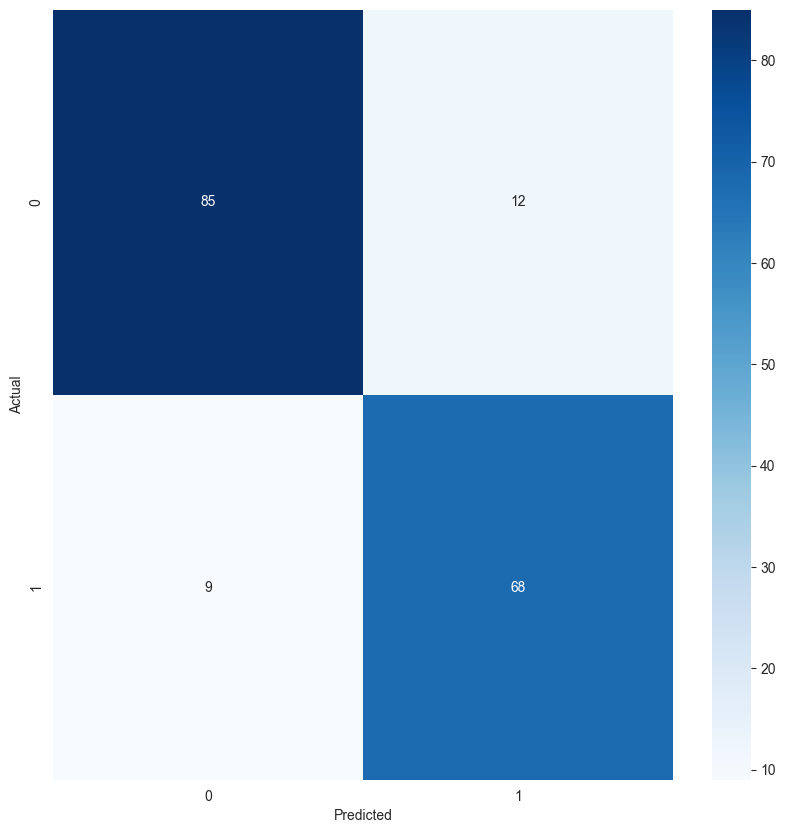

In [22]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
# Create a dataframe with the predictions
df_predictions = pd.DataFrame(
    {
        "text_to_analyse": X_test,
        "label": y_test,
        "prediction": predictions,
    }
)
df_predictions

,text_to_analyse,label,prediction
16331,termostato ibpro6 monocromo airzone think radio b 230902828 tto bloqueado test bateria,0,0
17238,azce6thinkrb sn f016f87 permanece atascado bateria cambiar bateria azce6thinkrb sn f016f87 permanece atascado bateria cambiar bateria,0,0
1007,funcionan blueface pantalla bloqueada pantalla azul arranca quedan termostato cable inteligente airzone blueface bl 3 enviar termostato,1,1
7085,pantalla termostato congela pone roja remoto control remoto congela pantalla pone roja,0,0
170,pantalla queda blanco pantalla queda blanco,1,1
...,...,...,...
6921,"vivienda sistema acuazone actualmente termostato azdi6bluefacecb pantalla azul logotipo \""airzone\ vivienda 4 blueface colocados comprobado resto habitaciones termostato funciona termostato cable inteligente sustitucion termostato",1,1
4833,pantalla funciona cara azul pantalla funciona,1,1
7556,cara azul pantalla azul entrada 43661,1,1
1634,blueface responde queda pillado termostato cara azul termostato blueface responde queda pillado,0,0


In [25]:
df_predictions[df_predictions["label"] != df_predictions["prediction"]]

,text_to_analyse,label,prediction
12488,funciona pantalla responde termostato airzone think 8z radio azce6thinkrb funciona pantalla responde,0,1
880,termostatos encienden.se queda pantalla negro termostato color airzone blueface 32z termostato enciende.se queda pantalla negro,0,1
17748,pantalla congela reemplaza bateria termostato reparar pantalla reemplazar bateria,0,1
18348,termostato funciona pantalla digital completamente negra termostato termostato funciona pantalla digital completamente negra,0,1
4272,ventilador parada muestran control remoto frio calor proporcionamos control remoto cliente reemplazo funciona correctamente mando distancia blue face negro simplemente pare ventilador disponible frio calor proporcionamos control remoto cliente reemplazo funciona correctamente,1,0
612,reso flexa 3 blueface cara azul funciona display,1,0
3495,webserver viene utilizado vincular sistema blueface queda pantalla blancp blueface blanco termostato blueface queda pantalla bloqueada blanco,1,0
248,liquido termostato blueface disuelto crea manchas termostato cable inteligente airzone blueface blan liquido termostato blueface disuelto,1,0
485,indicaciones cliente imagen termostato ve floja temperatura deja subas termostato zona pl necesitamos reparacion garantia reposicion,1,0
11731,tto azce6thinkcb averiado pantalla bloqueada tto azce6thinkcb averiado tto azce6thinkcb averiado pantalla bloqueada,0,1


In [30]:
df.loc[df_predictions[df_predictions["label"] != df_predictions["prediction"]].index]

,codigo,id_pieza,CODART_A3,CAR3,text_to_analyse,processed_text_to_analyse,label,similarity_prediction,Ground_truth
12488,AMXKYGOA6B,66270,AZCE6THINKRB,91,"NO FUNCIONA, LA PANTALLA NO RESPONDE. TERMOSTATO AIRZONE THINK 8Z RADIO AZCE6THINKRB NO FUNCIONA, LA PANTALLA NO RESPONDE.",funciona pantalla responde termostato airzone think 8z radio azce6thinkrb funciona pantalla responde,0,303,301
880,LWRSLNBTDB,32413,AZDI6BLUEFACECB,91,LOS TERMOSTATOS NO ENCIENDEN.SE QUEDA PANTALLA EN NEGRO TERMOSTATO COLOR AIRZONE BLUEFACE 32Z TERMOSTATO NO ENCIENDE.SE QUEDA LA PANTALLA EN NEGRO,termostatos encienden.se queda pantalla negro termostato color airzone blueface 32z termostato enciende.se queda pantalla negro,0,301,301
17748,MJEYMJZI20,84938,AZCE6THINKRN,91,LA PANTALLA SE CONGELA Y SE REEMPLAZA LA BATERÍA TERMOSTATO REPARAR LA PANTALLA Y REEMPLAZAR LA BATERÍA,pantalla congela reemplaza bateria termostato reparar pantalla reemplazar bateria,0,303,301
18348,LMJPAGLP00,87314,AZCE6THINKRB,91,el termostato ya no funciona _x000D_\npantalla digital completamente negra TERMOSTATO EL TERMOSTATO YA NO FUNCIONA PANTALLA DIGITAL COMPLETAMENTE NEGRA,termostato funciona pantalla digital completamente negra termostato termostato funciona pantalla digital completamente negra,0,303,301
4272,AWDRZWHS2E,41713,AZCE6BLUEFACECN,91,"Solo modo ventilador y parada se muestran en el control remoto (sin modo frío ni calor). Proporcionamos un control remoto a nuestro cliente: después del reemplazo, todo funciona correctamente. Mando a distancia BLUE FACE NEGRO Simplemente pare y modo ventilador disponible (sin modo frío ni calor). Le proporcionamos un nuevo control remoto a nuestro cliente, después del reemplazo, todo funciona correctamente.",ventilador parada muestran control remoto frio calor proporcionamos control remoto cliente reemplazo funciona correctamente mando distancia blue face negro simplemente pare ventilador disponible frio calor proporcionamos control remoto cliente reemplazo funciona correctamente,1,301,303
612,MMZPNGXP88,31614,AZCE6BLUEFACECB,91,Reso Flexa 3 y Blueface. CARA AZUL no funciona display,reso flexa 3 blueface cara azul funciona display,1,303,303
3495,B2PQZMZX33,39540,AZCE6BLUEFACECB,91,Webserver viene como utilizado y no se puede vincular al sistema_x000D_\n_x000D_\nBlueface se queda la pantalla en blancp BLUEFACE BLANCO Termostato Blueface se queda la pantalla bloqueada en blanco.,webserver viene utilizado vincular sistema blueface queda pantalla blancp blueface blanco termostato blueface queda pantalla bloqueada blanco,1,301,303
248,MGPTM2TU40,30370,AZDI6BLUEFACECB,91,EL LIQUIDO DEL TERMOSTATO BLUEFACE SE HA DISUELTO Y CREA MANCHAS TERMOSTATO CABLE INTELIGENTE AIRZONE BLUEFACE BLAN EL LIQUIDO DEL TERMOSTATO BLUEFACE SE HA DISUELTO,liquido termostato blueface disuelto crea manchas termostato cable inteligente airzone blueface blan liquido termostato blueface disuelto,1,301,303
485,M2LOMW9Q7F,31136,ZONAPLXTB,91,SEGUN INDICACIONES DEL CLIENTE: La imagen del termostato se ve muy floja y la temperatura no deja que la subas. TERMOSTATO DE ZONA PL. NECESITAMOS REPARACION EN GARANTIA O REPOSICION DEL MISMO.,indicaciones cliente imagen termostato ve floja temperatura deja subas termostato zona pl necesitamos reparacion garantia reposicion,1,305,303
11731,ZWTNAWAZ09,63517,AZCE6THINKCB,91,TTO AZCE6THINKCB AVERIADO. PANTALLA BLOQUEADA TTO AZCE6THINKCB AVERIADO TTO AZCE6THINKCB AVERIADO. PANTALLA BLOQUEADA,tto azce6thinkcb averiado pantalla bloqueada tto azce6thinkcb averiado tto azce6thinkcb averiado pantalla bloqueada,0,303,301


# Conformal prediction

In [75]:
import numpy as np
import matplotlib.pyplot as plt

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score

In [76]:
# Calculate Softmax score
# softmax_score = np.max(y_pred_proba, axis=1)

# Initialize the Conformal Prediction classifier
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
mapie_score.fit(X_cp, y_cp)

alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)

In [107]:
y_ps_score.shape

(389, 2, 1)

In [139]:
teste = pd.concat([X_test.copy(), y_test.copy()], axis=1)
teste["outlier"] = False
if y_ps_score is not None:
    for i in range(len(teste)):
        label_boolean = y_ps_score[i, :, 0]
        set_size = np.sum(label_boolean)
        if set_size > 1:
            teste.loc[df.index[i], "outlier"] = True

In [77]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=100,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}",
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

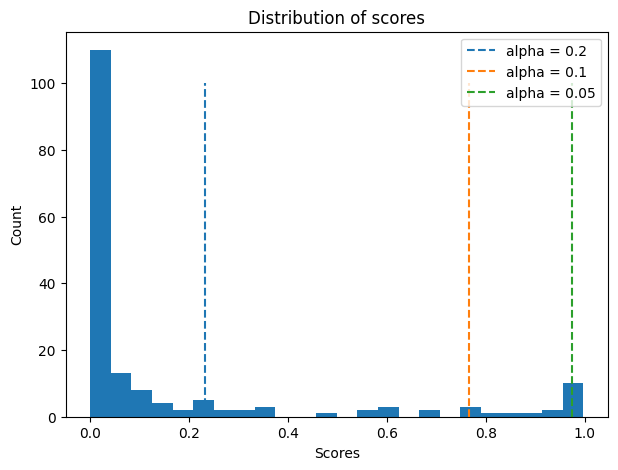

In [78]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_

plot_scores(n, alpha, scores, quantiles)

In [86]:
"""
    0: 301 - Bloqueado
    1: 303 - Pantalla
"""

df2 = pd.read_parquet("../../output_data/prod/temp_supervised_dataset_2.parquet")
teste = clf.predict_proba(df2[df2["label"] == 2]["processed_text_to_analyse"])

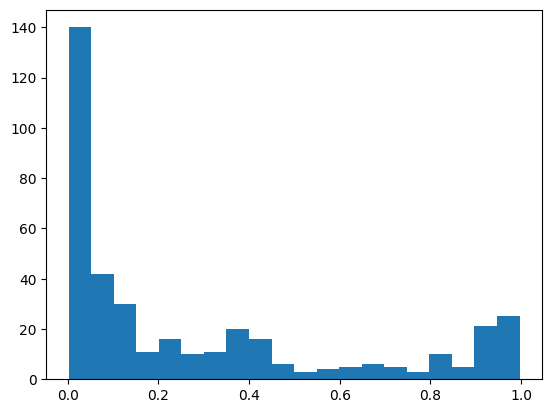

In [87]:
# Plot hist
plt.hist(teste[:, 1], bins=20)
plt.show()

In [95]:
(teste[0] > 0.1) & (teste[0] < 0.9) & (teste[1] > 0.1) & (teste[1] < 0.9)

array([False, False])

In [101]:
teste.shape

(389, 2)

In [102]:
teste[
    (teste[:, 0] > 0.05)
    & (teste[:, 0] < 0.95)
    & (teste[:, 0] > 0.05)
    & (teste[:, 0] < 0.95)
]

array([[0.7487137 , 0.25128636],
       [0.91418964, 0.08581033],
       [0.7632337 , 0.2367663 ],
       [0.6143129 , 0.38568714],
       [0.6476796 , 0.3523203 ],
       [0.89624876, 0.10375124],
       [0.25428477, 0.7457153 ],
       [0.34506223, 0.65493774],
       [0.6557296 , 0.34427038],
       [0.86133194, 0.13866812],
       [0.2995324 , 0.7004676 ],
       [0.2995324 , 0.7004676 ],
       [0.9405509 , 0.05944907],
       [0.94627   , 0.05372995],
       [0.7943125 , 0.20568748],
       [0.06860282, 0.93139714],
       [0.938235  , 0.061765  ],
       [0.9071637 , 0.09283628],
       [0.85309315, 0.14690687],
       [0.8915132 , 0.10848675],
       [0.13525353, 0.86474645],
       [0.5088101 , 0.4911899 ],
       [0.77189255, 0.22810741],
       [0.7663893 , 0.23361067],
       [0.7740639 , 0.22593608],
       [0.565413  , 0.434587  ],
       [0.8599302 , 0.14006981],
       [0.56044555, 0.43955442],
       [0.93465436, 0.06534562],
       [0.9290651 , 0.07093485],
       [0.

In [103]:
y_pred_score, y_ps_score = mapie_score.predict(
    df2[df2["label"] == 2]["processed_text_to_analyse"], alpha=0.1
)

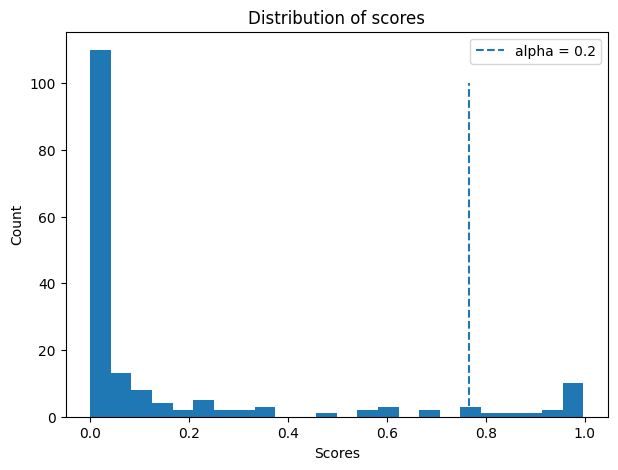

In [104]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_

plot_scores(n, alpha, scores, quantiles)

# Plot the training metrics

In [2]:
import matplotlib.pyplot as plt
import re

In [3]:
# Training metrics data as a string
training_data = """
{'loss': 1.1074, 'grad_norm': 14.107563972473145, 'learning_rate': 2e-05, 'epoch': 0.16}
{'loss': 0.6237, 'grad_norm': 7.904306411743164, 'learning_rate': 2e-05, 'epoch': 0.32}
{'loss': 0.5112, 'grad_norm': 7.12638521194458, 'learning_rate': 2e-05, 'epoch': 0.48}
{'loss': 0.3775, 'grad_norm': 4.049189567565918, 'learning_rate': 2e-05, 'epoch': 0.63}
{'loss': 0.413, 'grad_norm': 10.239442825317383, 'learning_rate': 2e-05, 'epoch': 0.79}
{'loss': 0.249, 'grad_norm': 3.4569692611694336, 'learning_rate': 2e-05, 'epoch': 0.95}
{'eval_loss': 0.28245222568511963, 'eval_runtime': 105.0607, 'eval_samples_per_second': 1.494, 'eval_steps_per_second': 0.19, 'epoch': 1.0}
{'loss': 0.2948, 'grad_norm': 10.092912673950195, 'learning_rate': 2e-05, 'epoch': 1.11}
{'loss': 0.303, 'grad_norm': 23.20924949645996, 'learning_rate': 2e-05, 'epoch': 1.27}
{'loss': 0.2528, 'grad_norm': 18.06032943725586, 'learning_rate': 2e-05, 'epoch': 1.43}
{'loss': 0.1111, 'grad_norm': 22.759109497070312, 'learning_rate': 2e-05, 'epoch': 1.59}
{'loss': 0.1172, 'grad_norm': 1.1877919435501099, 'learning_rate': 2e-05, 'epoch': 1.75}
{'loss': 0.2398, 'grad_norm': 3.0136420726776123, 'learning_rate': 2e-05, 'epoch': 1.9}
{'eval_loss': 0.2211766093969345, 'eval_runtime': 104.1499, 'eval_samples_per_second': 1.507, 'eval_steps_per_second': 0.192, 'epoch': 2.0}
{'loss': 0.1469, 'grad_norm': 13.05081844329834, 'learning_rate': 2e-05, 'epoch': 2.06}
{'loss': 0.0894, 'grad_norm': 0.05093025416135788, 'learning_rate': 2e-05, 'epoch': 2.22}
{'loss': 0.1927, 'grad_norm': 0.028336193412542343, 'learning_rate': 2e-05, 'epoch': 2.38}
{'loss': 0.071, 'grad_norm': 0.10689827799797058, 'learning_rate': 2e-05, 'epoch': 2.54}
{'loss': 0.1676, 'grad_norm': 41.53746032714844, 'learning_rate': 2e-05, 'epoch': 2.7}
{'loss': 0.1861, 'grad_norm': 35.64866638183594, 'learning_rate': 2e-05, 'epoch': 2.86}
{'eval_loss': 0.19358612596988678, 'eval_runtime': 104.9347, 'eval_samples_per_second': 1.496, 'eval_steps_per_second': 0.191, 'epoch': 3.0}
{'loss': 0.1249, 'grad_norm': 3.729599714279175, 'learning_rate': 2e-05, 'epoch': 3.02}
{'loss': 0.0132, 'grad_norm': 0.05018153041601181, 'learning_rate': 2e-05, 'epoch': 3.17}
{'loss': 0.0778, 'grad_norm': 0.029305703938007355, 'learning_rate': 2e-05, 'epoch': 3.33}
{'loss': 0.0422, 'grad_norm': 0.13734115660190582, 'learning_rate': 2e-05, 'epoch': 3.49}
{'loss': 0.0507, 'grad_norm': 0.18359579145908356, 'learning_rate': 2e-05, 'epoch': 3.65}
{'loss': 0.0414, 'grad_norm': 2.4170315265655518, 'learning_rate': 2e-05, 'epoch': 3.81}
{'loss': 0.0655, 'grad_norm': 0.042904771864414215, 'learning_rate': 2e-05, 'epoch': 3.97}
{'eval_loss': 0.29243889451026917, 'eval_runtime': 119.9047, 'eval_samples_per_second': 1.309, 'eval_steps_per_second': 0.167, 'epoch': 4.0}
{'loss': 0.0085, 'grad_norm': 0.0268461462110281, 'learning_rate': 2e-05, 'epoch': 4.13}
{'loss': 0.0215, 'grad_norm': 0.012776277959346771, 'learning_rate': 2e-05, 'epoch': 4.29}
{'loss': 0.0529, 'grad_norm': 16.013086318969727, 'learning_rate': 2e-05, 'epoch': 4.44}
{'loss': 0.0814, 'grad_norm': 2.3951380252838135, 'learning_rate': 2e-05, 'epoch': 4.6}
{'loss': 0.0436, 'grad_norm': 0.12002553045749664, 'learning_rate': 2e-05, 'epoch': 4.76}
{'loss': 0.0645, 'grad_norm': 2.722397565841675, 'learning_rate': 2e-05, 'epoch': 4.92}
{'eval_loss': 0.2142232358455658, 'eval_runtime': 106.9668, 'eval_samples_per_second': 1.468, 'eval_steps_per_second': 0.187, 'epoch': 5.0}
"""

Plot saved as training_loss_plot.png


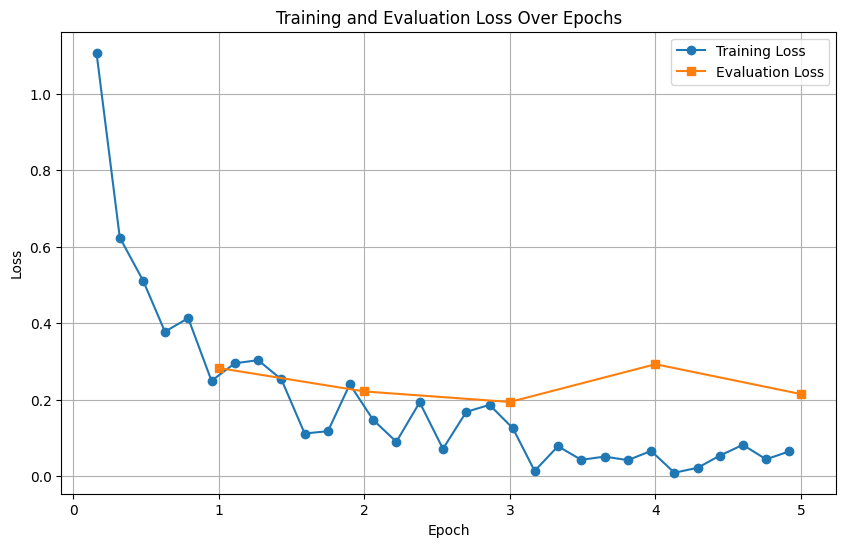

In [4]:
# Extract data using regex
train_loss = []
eval_loss = []
epochs_train = []
epochs_eval = []

for match in re.finditer(r"'loss': ([0-9\.]+).*'epoch': ([0-9\.]+)", training_data):
    train_loss.append(float(match.group(1)))
    epochs_train.append(float(match.group(2)))

for match in re.finditer(
    r"'eval_loss': ([0-9\.]+).*'epoch': ([0-9\.]+)", training_data
):
    eval_loss.append(float(match.group(1)))
    epochs_eval.append(float(match.group(2)))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(epochs_train, train_loss, label="Training Loss", marker="o")
plt.plot(epochs_eval, eval_loss, label="Evaluation Loss", marker="s")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Save the plot to disk
output_file = "training_loss_plot.png"
plt.savefig(output_file)
print(f"Plot saved as {output_file}")

# Show the plot (optional)
plt.show()